In [1]:
import torch
import matplotlib.pyplot as plt

# Task 1.

In [2]:
# Генерация синтетических данных
torch.manual_seed(42)
n_samples = 100
demand = torch.linspace(0, 10, n_samples)  # Спрос
weather = torch.randint(0, 3, (n_samples,))  # Погодные условия (0, 1, 2)
seasonality = torch.sin(demand / 2)  # Сезонность

true_params = torch.tensor([50.0, 10.0, -5.0, 20.0])  # w0, w1, w2, w3
noise = torch.normal(0, 5, (n_samples,))
price = (
    true_params[0] 
    + true_params[1] * demand 
    + true_params[2] * weather 
    + true_params[3] * seasonality 
    + noise
)

In [3]:
# Матрица признаков
X = torch.stack([
    torch.ones(n_samples),
    demand,
    weather.float(),
    seasonality
], dim=1)

In [4]:
# Реализация алгоритма Гиббса
def gibbs_sampling(n_iterations=5000, sigma_squared=25.0):
    w = torch.zeros(4)
    samples = []
    for _ in range(n_iterations):
        for i in range(4):
            current_pred = torch.matmul(X, w)
            residual = price - (current_pred - w[i] * X[:, i])
            X_i = X[:, i]
            
            X_i_T_y = torch.dot(X_i, residual)
            X_i_T_X_i = torch.sum(X_i ** 2)
            
            mu_post = X_i_T_y / (X_i_T_X_i + sigma_squared)
            tau_sq = sigma_squared / (X_i_T_X_i + sigma_squared)
            
            w[i] = torch.normal(mu_post, torch.sqrt(tau_sq))
        samples.append(w.clone())
    return torch.stack(samples)

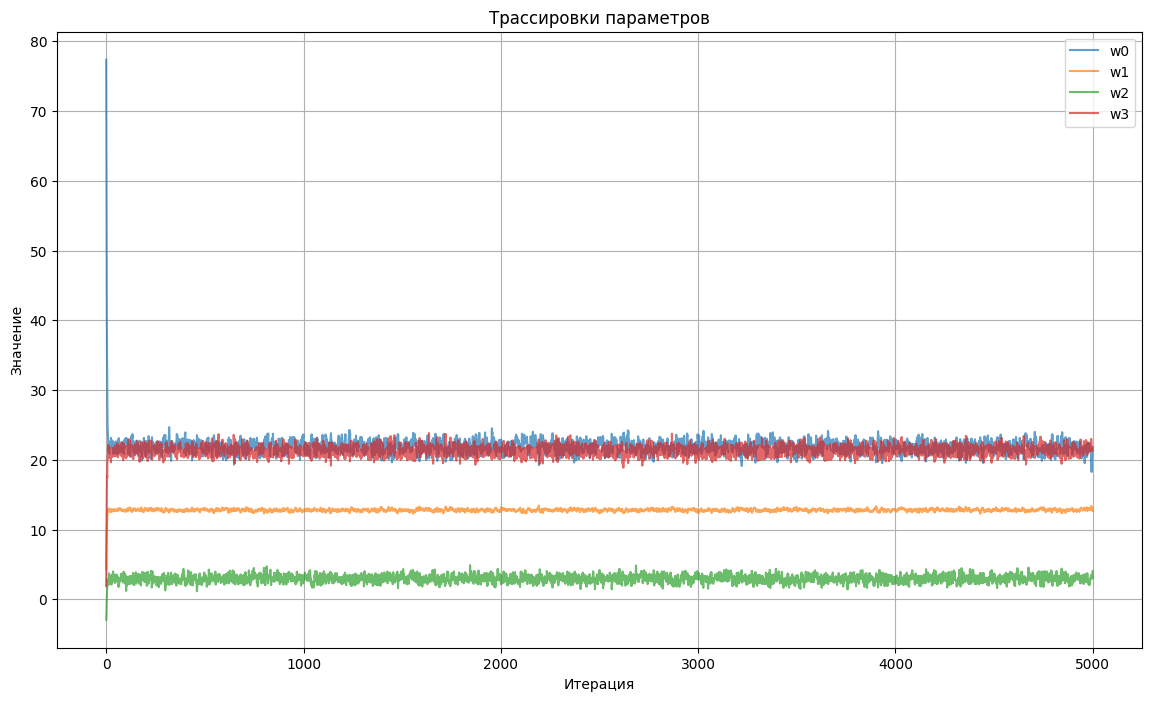

In [5]:
# Запуск алгоритма
samples = gibbs_sampling(n_iterations=5000)

# Визуализация выборки параметров
plt.figure(figsize=(14, 8))
for i, name in enumerate(["w0", "w1", "w2", "w3"]):
    plt.plot(samples[:, i], label=name, alpha=0.7)
plt.title("Трассировки параметров")
plt.xlabel("Итерация")
plt.ylabel("Значение")
plt.legend()
plt.grid()
plt.show()

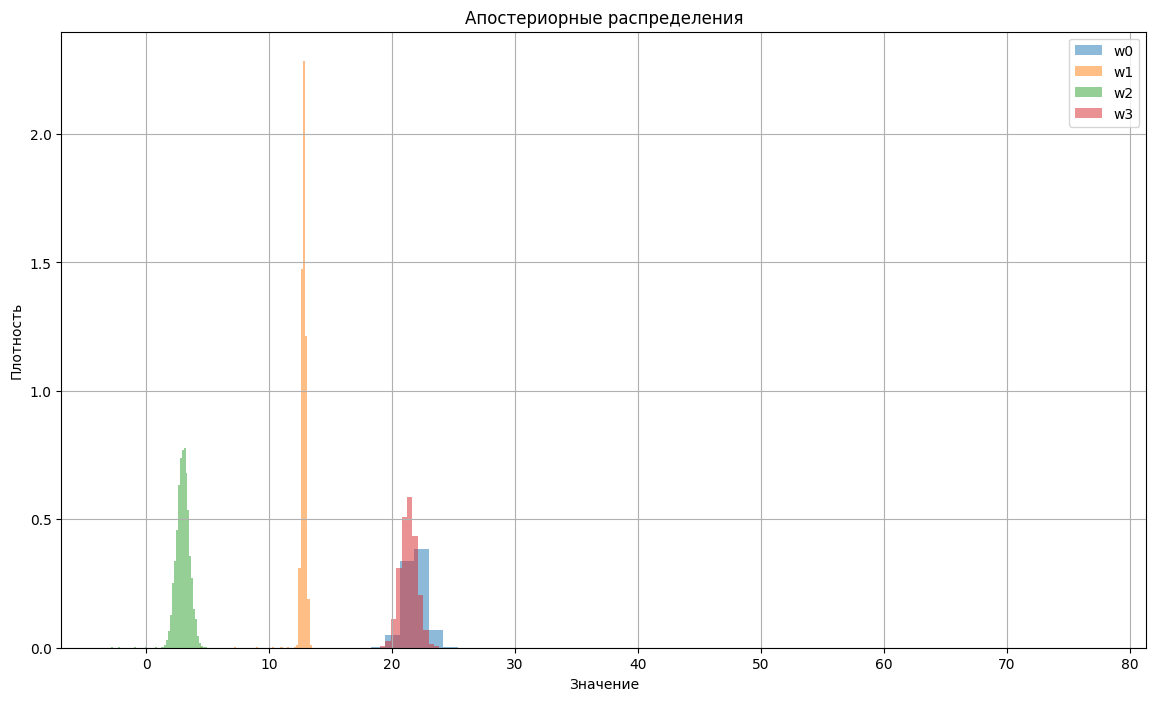

In [6]:
# Апостериорные распределения
plt.figure(figsize=(14, 8))
for i, name in enumerate(["w0", "w1", "w2", "w3"]):
    plt.hist(samples[:, i], bins=50, alpha=0.5, label=name, density=True)
plt.title("Апостериорные распределения")
plt.xlabel("Значение")
plt.ylabel("Плотность")
plt.legend()
plt.grid()
plt.show()

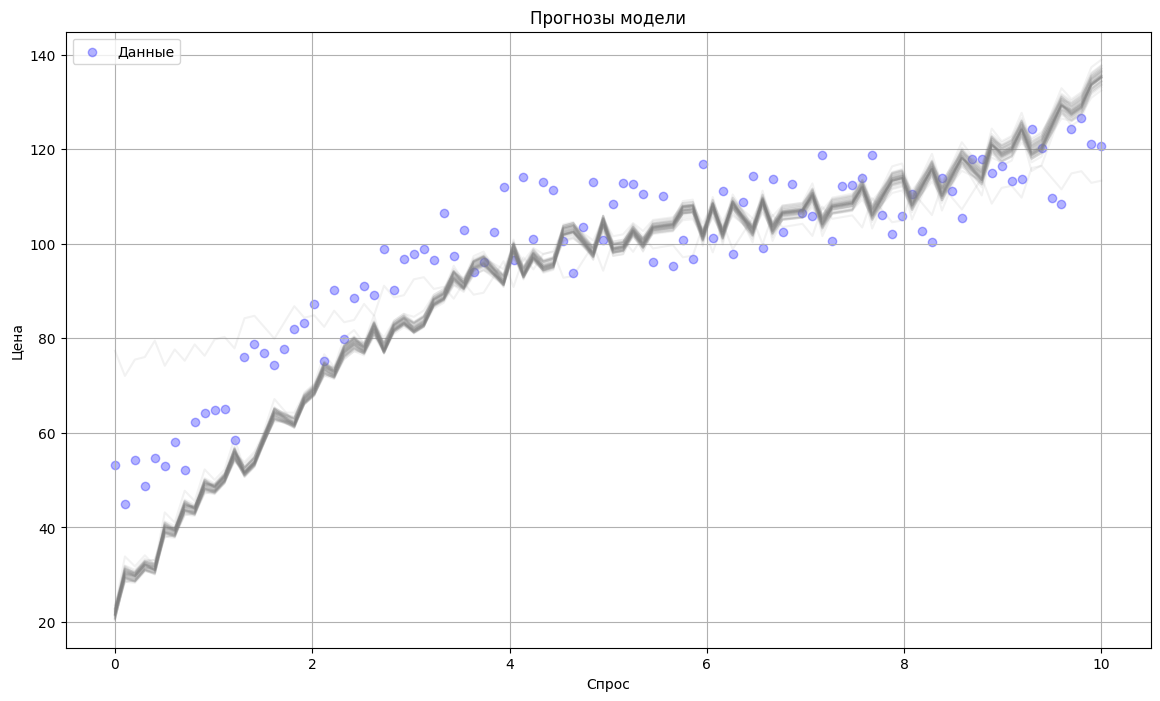

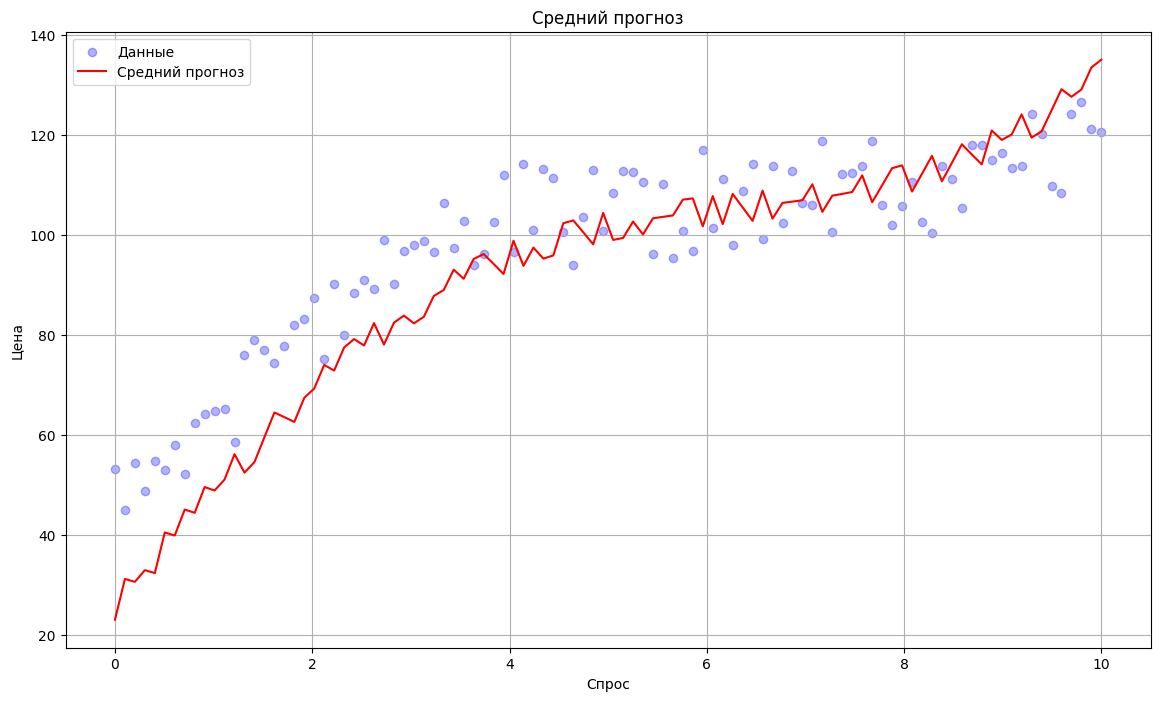

In [7]:
# Прогнозы и средний прогноз
thin_samples = samples[::100]
predictions = []
for s in thin_samples:
    pred = s[0] + s[1]*demand + s[2]*weather + s[3]*seasonality
    predictions.append(pred)

plt.figure(figsize=(14, 8))
for pred in predictions:
    plt.plot(demand, pred, color='gray', alpha=0.1)
plt.scatter(demand, price, c='blue', label='Данные', alpha=0.3)
plt.title("Прогнозы модели")
plt.xlabel("Спрос")
plt.ylabel("Цена")
plt.legend()
plt.grid()
plt.show()

mean_pred = torch.mean(torch.stack(predictions), dim=0)
plt.figure(figsize=(14, 8))
plt.scatter(demand, price, c='blue', label='Данные', alpha=0.3)
plt.plot(demand, mean_pred, 'r-', label='Средний прогноз')
plt.title("Средний прогноз")
plt.xlabel("Спрос")
plt.ylabel("Цена")
plt.legend()
plt.grid()
plt.show()

# Task 2.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
np.random.seed(42)
n_samples = 1000
n_features = 8

In [10]:
# Истинные параметры (w0 - intercept)
w_true = np.array([10.0, 0.5, 2.0, -1.5, 0.3, 1.0, -0.5, 0.2, 5.0])

# Создание матрицы признаков
X = np.ones((n_samples, 9))  # Добавляем столбец для intercept
X[:, 1] = np.random.randint(10, 100, n_samples)          # Спрос
X[:, 2] = np.random.randint(0, 3, n_samples)             # Погода
X[:, 3] = np.random.randint(0, 24, n_samples)            # Час суток
X[:, 4] = np.random.randint(1, 8, n_samples)             # День недели
X[:, 5] = np.random.randint(1, 51, n_samples)            # Расстояние
X[:, 6] = np.random.randint(0, 11, n_samples)            # Плотность трафика
X[:, 7] = np.random.randint(0, 21, n_samples)            # Конкуренция
X[:, 8] = np.random.randint(0, 2, n_samples)             # Сезонность

# Генерация целевой переменной
sigma_noise = 2.0
y = X.dot(w_true) + np.random.normal(0, sigma_noise, n_samples)

In [11]:
def log_likelihood(theta, X, y, sigma):
    y_pred = X.dot(theta)
    return -0.5 * np.sum((y - y_pred)**2) / (sigma**2)

def log_prior(theta, prior_var=100.0):
    return -0.5 * np.sum(theta**2) / prior_var

def log_target(theta, X, y, sigma, prior_var):
    return log_likelihood(theta, X, y, sigma) + log_prior(theta, prior_var)

def metropolis_hastings(X, y, sigma, prior_var, n_samples=5000, proposal_std=0.1):
    n_params = X.shape[1]
    theta = np.random.normal(0, 1, n_params)
    samples = []
    accepted = 0
    
    for _ in range(n_samples):
        theta_new = theta + np.random.normal(0, proposal_std, n_params)
        log_r = log_target(theta_new, X, y, sigma, prior_var) - log_target(theta, X, y, sigma, prior_var)
        
        if np.log(np.random.rand()) < log_r:
            theta = theta_new
            accepted += 1
        samples.append(theta.copy())
    
    acceptance_rate = accepted / n_samples
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    return np.array(samples)

In [12]:
def gibbs_sampling(X, y, sigma, prior_var, n_samples=5000):
    n_params = X.shape[1]
    theta = np.random.normal(0, 1, n_params)
    samples = []
    XT_X = np.sum(X**2, axis=0)
    
    for _ in range(n_samples):
        for j in range(n_params):
            # Остатки без j-го параметра
            r = y - X.dot(theta) + X[:, j] * theta[j]
            numerator = np.dot(X[:, j], r)
            denominator = XT_X[j] + (sigma**2) / prior_var
            mu_j = numerator / denominator
            sigma_j = np.sqrt(sigma**2 / denominator)
            theta[j] = np.random.normal(mu_j, sigma_j)
        samples.append(theta.copy())
    
    return np.array(samples)

In [13]:
sigma = 2.0
prior_var = 10.0

samples_mh = metropolis_hastings(
    X, y, sigma, prior_var, 
    n_samples=10000,  
    proposal_std=1.0 
)
samples_gibbs = gibbs_sampling(X, y, sigma, prior_var)

Acceptance rate: 0.00


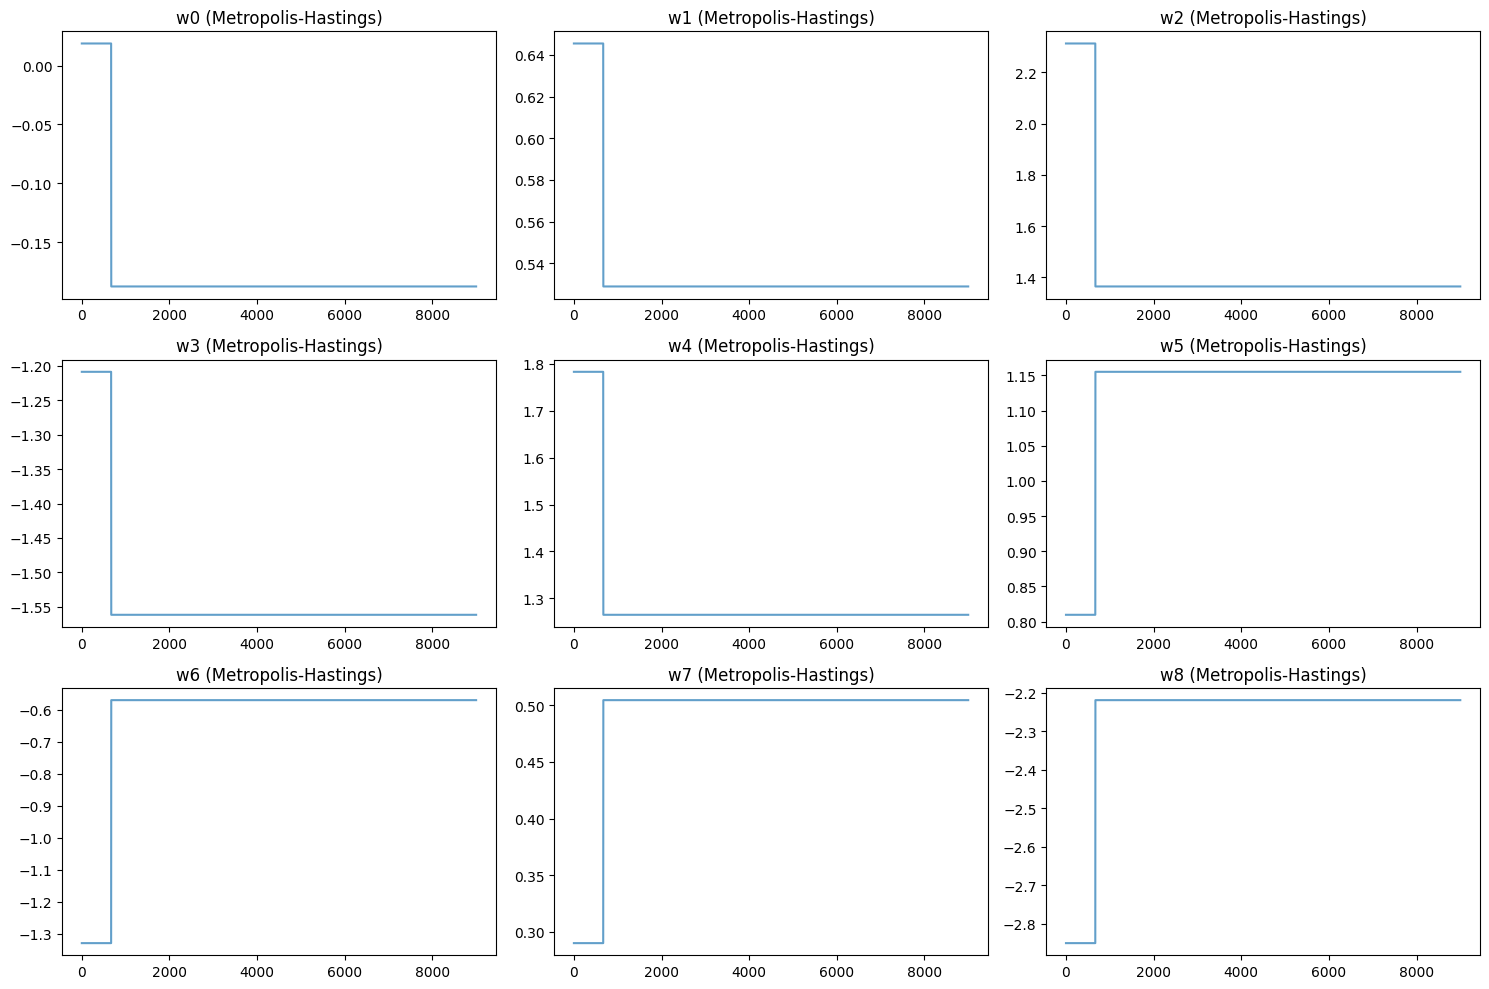

In [14]:
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(samples_mh[1000:, i], alpha=0.7)
    plt.title(f'w{i} (Metropolis-Hastings)')
plt.tight_layout()
plt.show()

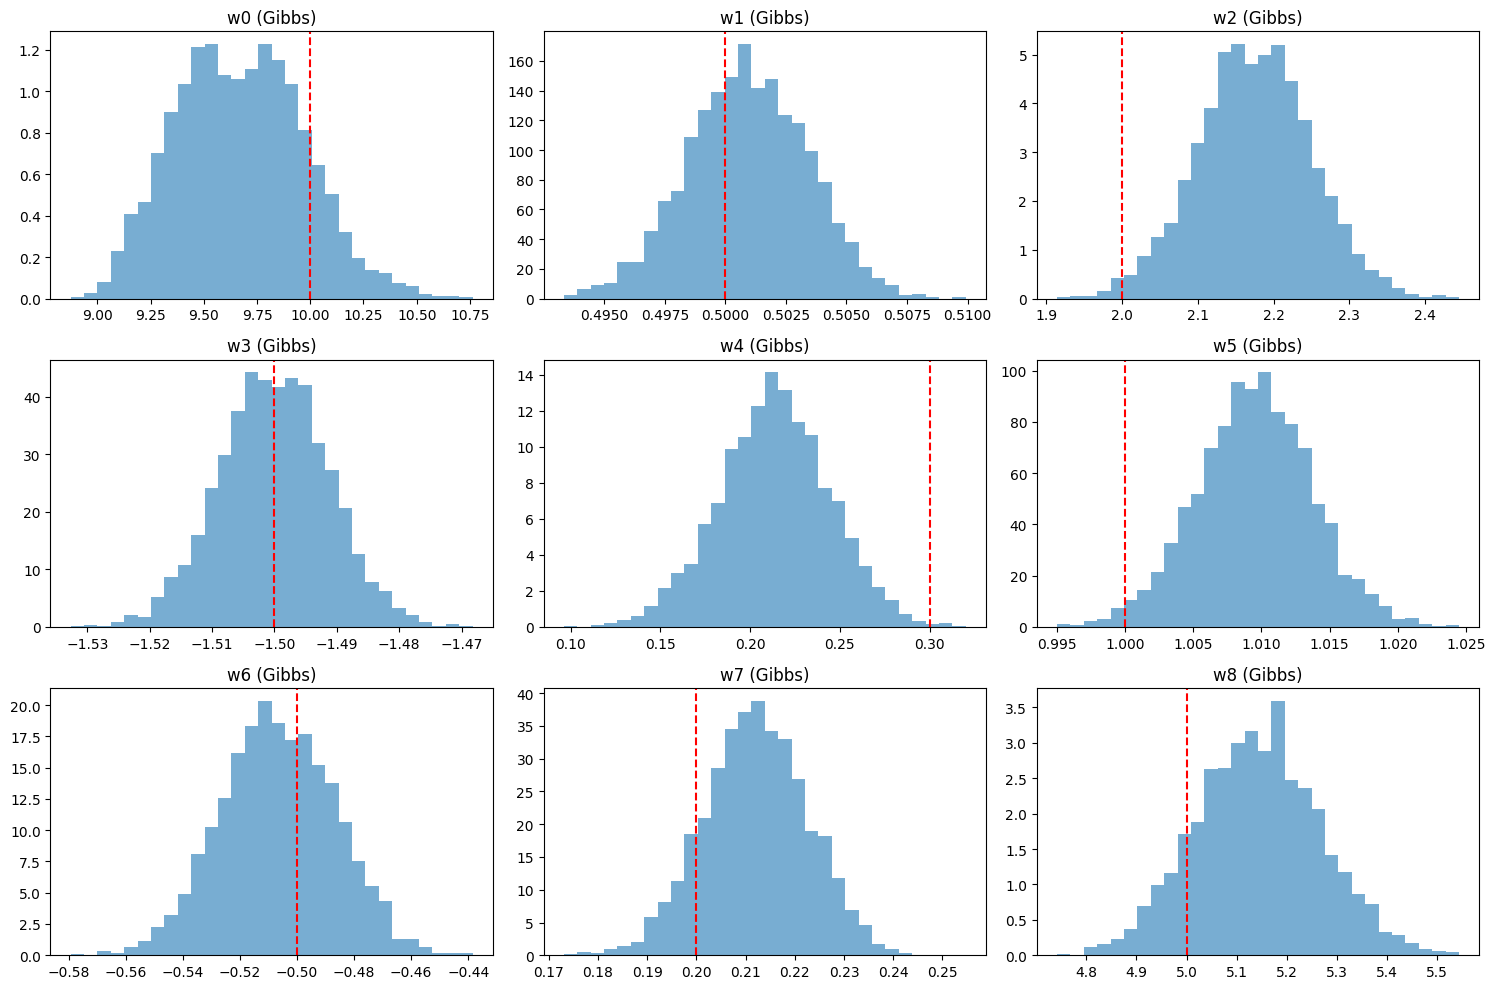

In [15]:
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.hist(samples_gibbs[1000:, i], bins=30, density=True, alpha=0.6)
    plt.axvline(w_true[i], color='r', linestyle='--')
    plt.title(f'w{i} (Gibbs)')
plt.tight_layout()
plt.show()

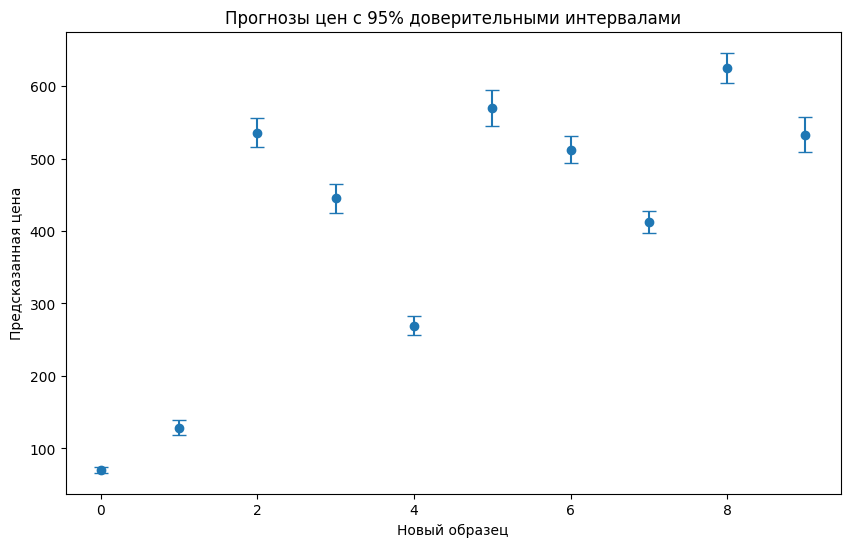

In [16]:
# Генерация новых данных
X_new = np.ones((10, 9))
X_new[:, 1:] = np.random.randint(0, 100, (10, 8))  # Пример заполнения

# Прогнозы
samples = samples_gibbs[1000:]
predictions = np.dot(X_new, samples.T)
mean_pred = predictions.mean(axis=1)
std_pred = predictions.std(axis=1)

plt.figure(figsize=(10, 6))
plt.errorbar(range(10), mean_pred, yerr=2*std_pred, fmt='o', capsize=5)
plt.xlabel('Новый образец')
plt.ylabel('Предсказанная цена')
plt.title('Прогнозы цен с 95% доверительными интервалами')
plt.show()

*Сравнение результатов:* 

Метрополис-Хастингс (MH): Параметры демонстрируют высокую автокорреляцию

Траектории более "шумные" и менее коррелированные, так как каждый параметр обновляется независимо. Для w2 значения стабилизируются быстрее, а гистограмма имеет узкий пик около истинного значения.

*Сходимость:* Гиббс эффективнее в задачах с аналитическими условными распределениями, например линейная регрессия. MH требует больше вычислительных ресурсов.

*Улучшения:* Если параметры независимы (ковариационная матрица диагональна), то используем диагональные ковариционные матрицы

Если параметры коррелируют (например, "час суток" и "плотность трафика"), диагональная матрица приведет к медленной сходимости. В таком случае можно использовать блочного Гиббса.

Регуляризация априорного распределения стабилизирует оценки при мультиколлинеарности

Также меньшает переобучение, особенно при малом объеме данных.